In [1]:
from pathlib import Path
import json

%matplotlib inline
import numpy as np
import pandas as pd
from collections import defaultdict

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
from torchvision.models import resnet34
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
from custom_datasets import YogaPoseDataset

import model_utils
import plot_utils

In [2]:
JPEG_DIR = Path('dataset/')

In [3]:
pose_list = json.load(Path('pose-list-with-meta.json').open())

In [4]:
'''
pose_id_to_name = {}
for i in pose_list:
    pose_id_to_name[i['id']] = i['sanskrit_name']
'''    

In [4]:
pose_id_to_name = {0: 'Bharadvajasana I', 1: 'Padangusthasana', 2: 'Paripurna Navasana', 3: 'Baddha Konasana', 4: 'Dhanurasana', 5: 'Setu Bandha Sarvangasana', 6: 'Ustrasana', 7: 'Marjaryasana', 8: 'Chakravakasana', 9: 'Ashtanga Namaskara', 10: 'Utkatasana', 11: 'Balasana', 12: 'Bhujangasana', 13: 'Savasana', 14: 'Gomukhasana', 15: 'Bitilasana', 16: 'Bakasana', 17: 'Makara Adho Mukha Svanasana', 18: 'Ardha Pincha Mayurasana', 19: 'Adho Mukha Svanasana', 20: 'Garudasana', 21: 'Sukhasana', 22: 'Astavakrasana', 23: 'Utthita Hasta Padangustasana', 24: 'Uttana Shishosana', 25: 'Utthita Parsvakonasana', 26: 'Utthita Trikonasana', 27: 'Pincha Mayurasana', 28: 'Agnistambhasana', 29: 'Tittibhasana', 30: 'Matsyasana', 31: 'Chaturanga Dandasana', 32: 'Malasana', 33: 'Parighasana', 34: 'Ardha Bhekasana', 35: 'Ardha Matsyendrasana', 36: 'Supta Matsyendrasana', 37: 'Ardha Chandrasana', 38: 'Adho Mukha Vriksasana', 39: 'Ananda Balasana', 40: 'Janu Sirsasana', 41: 'Virasana', 42: 'Krounchasana', 43: 'Utthita Ashwa Sanchalanasana', 44: 'Parsvottanasana', 45: 'Viparita Karani', 46: 'Salabhasana', 47: 'Natarajasana', 48: 'Padmasana', 49: 'Anjaneyasana', 50: 'Marichyasana III', 51: 'Hanumanasana', 52: 'Tadasana', 53: 'Pasasana', 54: 'Eka Pada Rajakapotasana', 55: 'Eka Pada Rajakapotasana II', 56: 'Mayurasana', 57: 'Kapotasana', 58: 'Phalakasana', 59: 'Halasana', 60: 'Eka Pada Koundinyanasana I', 61: 'Eka Pada Koundinyanasana II', 62: 'Marichyasana I', 63: 'Supta Baddha Konasana', 64: 'Supta Padangusthasana', 65: 'Supta Virasana', 66: 'Parivrtta Janu Sirsasana', 67: 'Parivrtta Parsvakonasana', 68: 'Parivrtta Trikonasana', 69: 'Tolasana', 70: 'Paschimottanasana', 72: 'Parsva Bakasana', 73: 'Vasisthasana', 74: 'Anantasana', 75: 'Salamba Bhujangasana', 76: 'Dandasana', 77: 'Uttanasana', 78: 'Ardha Uttanasana', 79: 'Urdhva Prasarita Eka Padasana', 80: 'Salamba Sirsasana', 81: 'Salamba Sarvangasana', 82: 'Vriksasana', 83: 'Urdhva Dhanurasana', 84: 'Dwi Pada Viparita Dandasana', 85: 'Purvottanasana', 86: 'Urdhva Hastasana', 87: 'Urdhva Mukha Svanasana', 88: 'Virabhadrasana I', 89: 'Virabhadrasana II', 90: 'Virabhadrasana III', 91: 'Upavistha Konasana', 92: 'Prasarita Padottanasana', 93: 'Camatkarasana', 94: 'Yoganidrasana', 95: 'Vrischikasana', 96: 'Vajrasana', 97: 'Tulasana', 98: 'Simhasana', 99: 'Makarasana', 100: 'Lolasana', 101: 'Kurmasana', 102: 'Garbha Pindasana', 103: 'Durvasasana', 71: 'Bhujapidasana', 104: 'Bhekasana', 105: 'Bhairavasana', 106: 'Ganda Bherundasana'}

In [5]:
pose_name_to_id = {'bharadvajasana i': 0, 'padangusthasana': 1, 'paripurna navasana': 2, 'baddha konasana': 3, 'dhanurasana': 4, 'setu bandha sarvangasana': 5, 'ustrasana': 6, 'marjaryasana': 7, 'chakravakasana': 8, 'ashtanga namaskara': 9, 'utkatasana': 10, 'balasana': 11, 'bhujangasana': 12, 'savasana': 13, 'gomukhasana': 14, 'bitilasana': 15, 'bakasana': 16, 'makara adho mukha svanasana': 17, 'ardha pincha mayurasana': 18, 'adho mukha svanasana': 19, 'garudasana': 20, 'sukhasana': 21, 'astavakrasana': 22, 'utthita hasta padangustasana': 23, 'uttana shishosana': 24, 'utthita parsvakonasana': 25, 'utthita trikonasana': 26, 'pincha mayurasana': 27, 'agnistambhasana': 28, 'tittibhasana': 29, 'matsyasana': 30, 'chaturanga dandasana': 31, 'malasana': 32, 'parighasana': 33, 'ardha bhekasana': 34, 'ardha matsyendrasana': 35, 'supta matsyendrasana': 36, 'ardha chandrasana': 37, 'adho mukha vriksasana': 38, 'ananda balasana': 39, 'janu sirsasana': 40, 'virasana': 41, 'krounchasana': 42, 'utthita ashwa sanchalanasana': 43, 'parsvottanasana': 44, 'viparita karani': 45, 'salabhasana': 46, 'natarajasana': 47, 'padmasana': 48, 'anjaneyasana': 49, 'marichyasana iii': 50, 'hanumanasana': 51, 'tadasana': 52, 'pasasana': 53, 'eka pada rajakapotasana': 54, 'eka pada rajakapotasana ii': 55, 'mayurasana': 56, 'kapotasana': 57, 'phalakasana': 58, 'halasana': 59, 'eka pada koundinyanasana i': 60, 'eka pada koundinyanasana ii': 61, 'marichyasana i': 62, 'supta baddha konasana': 63, 'supta padangusthasana': 64, 'supta virasana': 65, 'parivrtta janu sirsasana': 66, 'parivrtta parsvakonasana': 67, 'parivrtta trikonasana': 68, 'tolasana': 69, 'paschimottanasana': 70, 'parsva bakasana': 72, 'vasisthasana': 73, 'anantasana': 74, 'salamba bhujangasana': 75, 'dandasana': 76, 'uttanasana': 77, 'ardha uttanasana': 78, 'urdhva prasarita eka padasana': 79, 'salamba sirsasana': 80, 'salamba sarvangasana': 81, 'vriksasana': 82, 'urdhva dhanurasana': 83, 'dwi pada viparita dandasana': 84, 'purvottanasana': 85, 'urdhva hastasana': 86, 'urdhva mukha svanasana': 87, 'virabhadrasana i': 88, 'virabhadrasana ii': 89, 'virabhadrasana iii': 90, 'upavistha konasana': 91, 'prasarita padottanasana': 92, 'camatkarasana': 93, 'yoganidrasana': 94, 'vrischikasana': 95, 'vajrasana': 96, 'tulasana': 97, 'simhasana': 98, 'makarasana': 99, 'lolasana': 100, 'kurmasana': 101, 'garbha pindasana': 102, 'durvasasana': 103, 'bhujapidasana': 71, 'bhekasana': 104, 'bhairavasana': 105, 'ganda bherundasana': 106}

In [7]:
'''
pose_name_to_id = {}
for k,v in pose_id_to_name.items():
    pose_name_to_id[v.lower()] = k  
'''    

In [7]:
'''
im_counts = {}
for p in JPEG_DIR.iterdir():
    if(str(p).split('/')[-1]!='.DS_Store'):
        im_counts[str(p).split('/')[-1]] = len(list(p.iterdir()))-1
'''
im_counts = {'ashtanga namaskara': 34, 'chakravakasana': 70, 'eka pada rajakapotasana ii': 55, 'anantasana': 43, 'kapotasana': 57, 'hanumanasana': 35, 'parighasana': 43, 'marichyasana i': 49, 'tittibhasana': 57, 'janu sirsasana': 48, 'yoganidrasana': 46, 'kurmasana': 40, 'ananda balasana': 59, 'krounchasana': 45, 'phalakasana': 57, 'garbha pindasana': 36, 'adho mukha svanasana': 70, 'eka pada koundinyanasana i': 51, 'vajrasana': 54, 'padmasana': 68, 'virabhadrasana i': 55, 'salamba bhujangasana': 55, 'parivrtta trikonasana': 62, 'supta virasana': 60, 'lolasana': 36, 'supta baddha konasana': 71, 'upavistha konasana': 60, 'tolasana': 60, 'simhasana': 49, 'ardha pincha mayurasana': 47, 'ardha bhekasana': 40, 'camatkarasana': 54, 'malasana': 68, 'uttanasana': 63, 'urdhva mukha svanasana': 63, 'tadasana': 56, 'durvasasana': 39, 'eka pada koundinyanasana ii': 58, 'chaturanga dandasana': 90, 'virasana': 50, 'natarajasana': 72, 'ustrasana': 87, 'baddha konasana': 70, 'bhekasana': 39, 'matsyasana': 57, 'utthita hasta padangustasana': 59, 'parsva bakasana': 56, 'marichyasana iii': 33, 'dandasana': 60, 'tulasana': 31, 'utkatasana': 73, 'purvottanasana': 63, 'sukhasana': 50, 'bhujangasana': 73, 'viparita karani': 69, 'vasisthasana': 74, 'makarasana': 57, 'bakasana': 77, 'ardha chandrasana': 52, 'astavakrasana': 72, 'gomukhasana': 72, 'bharadvajasana i': 54, 'utthita parsvakonasana': 63, 'urdhva prasarita eka padasana': 53, 'mayurasana': 51, 'adho mukha vriksasana': 59, 'anjaneyasana': 64, 'salamba sarvangasana': 67, 'agnistambhasana': 33, 'prasarita padottanasana': 66, 'utthita ashwa sanchalanasana': 38, 'dwi pada viparita dandasana': 55, 'ardha matsyendrasana': 90, 'paschimottanasana': 56, 'ganda bherundasana': 39, 'padangusthasana': 18, 'salabhasana': 58, 'virabhadrasana iii': 61, 'virabhadrasana ii': 56, 'garudasana': 78, 'setu bandha sarvangasana': 58, 'ardha uttanasana': 67, 'halasana': 66, 'pincha mayurasana': 35, 'supta padangusthasana': 62, 'urdhva hastasana': 47, 'uttana shishosana': 50, 'parivrtta janu sirsasana': 39, 'vrischikasana': 51, 'urdhva dhanurasana': 68, 'utthita trikonasana': 69, 'paripurna navasana': 68, 'bitilasana': 87, 'parivrtta parsvakonasana': 40, 'bhujapidasana': 61, 'balasana': 72, 'bhairavasana': 46, 'salamba sirsasana': 60, 'vriksasana': 62, 'eka pada rajakapotasana': 44, 'dhanurasana': 46, 'marjaryasana': 46, 'savasana': 57, 'parsvottanasana': 35, 'supta matsyendrasana': 54, 'makara adho mukha svanasana': 43, 'pasasana': 56}        

In [6]:
#labels = im_counts.keys()
#counts = im_counts.values()

#plot_utils.plot_horizontal_bar_chart(counts, labels, title='class wise images')        

In [11]:
'''
csv_data = {'file_name':[], 'pose_id':[], 'pose_name':[]}
for p in JPEG_DIR.iterdir():
    if str(p).split('/')[-1]!='.DS_Store':
        files = list(p.glob('*.jpg'))
        files.extend(list(p.glob('*.jpeg')))
        files.extend(list(p.glob('*.png')))
        
        for im in files:
            csv_data['file_name'].append(str(im)) 
            csv_data['pose_id'].append(pose_name_to_id[str(p).split('/')[-1]])
            csv_data['pose_name'].append(str(p).split('/')[-1])  


df = pd.DataFrame(data=csv_data)
df.to_csv('classifier_train_data.csv',index=False)
''' 

In [9]:
classifier_csv = pd.read_csv('classifier_train_data.csv')

In [10]:
from PIL import ImageOps
from PIL import Image

class Resize(object):
    def __init__(self, size=224):
        self.size = size
        
    def __call__(self, im):  
        if(im.height > im.width):
            
            w = int(self.size*im.width/im.height)
            h = self.size
            pad_val = int((224-w)/2)
            pad = (224-w-pad_val,0,pad_val,0)
        else:
            h = int(self.size*im.height/im.width)
            w = self.size
            pad_val = int((224-h)/2)
            pad = (0,224-h-pad_val,0,pad_val)
        return ImageOps.expand(im.resize((w,h),resample=Image.BILINEAR), pad)

In [11]:
im = Image.open(classifier_csv['file_name'][1432])

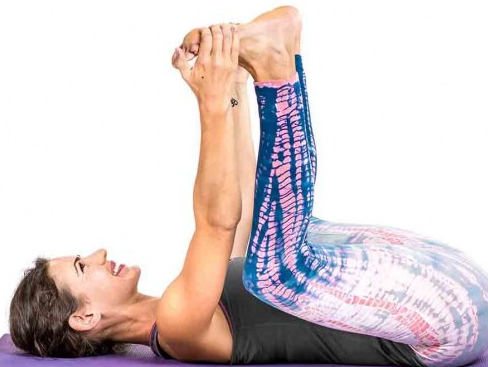

In [12]:
im

In [15]:
bs = 32
sz = 224
n_epochs = 1
lr = 0.001

trn_tfms = transforms.Compose([
    Resize(),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor()
])

val_tfms = transforms.Compose([
    Resize(),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor()
])

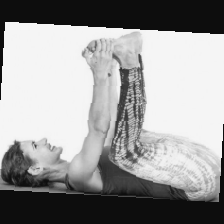

In [16]:
p = transforms.ToPILImage()
p(trn_tfms(im))

In [41]:
dl = torch.utils.data.DataLoader(YogaPoseDataset('classifier_train_data.csv', trn_tfms, 
                                                           pose_id_to_name, pose_name_to_id),
                                           bs, 
                                           shuffle=True)

In [9]:
model = resnet34(pretrained=True)
model.fc = nn.Linear(512, 107)   
model_utils.freeze_all_layers(model)
model = model.to(device)

In [47]:
'''
for param in model.parameters():
    param.requires_grad = True
'''    

In [50]:
model.train()
n_epochs = 2
lr = 0.00001
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

total_steps = 0
for e in range(n_epochs):
    avg_batch_accuracy = []
    for batch, labels in dl:
        optimizer.zero_grad()
        
        batch = batch.to(device)
        labels = labels.to(device)
        
        preds = model(batch)
        loss = loss_fn(preds, labels)
        
        loss.backward()
        optimizer.step()
                
        pred_labels = preds.argmax(dim=1)
        total_steps +=1
        batch_accuracy = (labels == pred_labels).float().mean()   
        avg_batch_accuracy.append(batch_accuracy.item())
        model_utils.print_training_loss_summary(loss.item(), total_steps, e+1, n_epochs, len(dl))
    
    print('avg batch accuracy:{:.2f}'.format(np.array(avg_batch_accuracy).mean()))

Epoch [1/2], Iteration [1/188], Loss: 0.1746
Epoch [1/2], Iteration [10/188], Loss: 0.0910
Epoch [1/2], Iteration [20/188], Loss: 0.1276
Epoch [1/2], Iteration [30/188], Loss: 0.1436
Epoch [1/2], Iteration [40/188], Loss: 0.0544
Epoch [1/2], Iteration [50/188], Loss: 0.1453
Epoch [1/2], Iteration [60/188], Loss: 0.1687
Epoch [1/2], Iteration [70/188], Loss: 0.0845
Epoch [1/2], Iteration [80/188], Loss: 0.1241
Epoch [1/2], Iteration [90/188], Loss: 0.2186
Epoch [1/2], Iteration [100/188], Loss: 0.1162
Epoch [1/2], Iteration [110/188], Loss: 0.1525
Epoch [1/2], Iteration [120/188], Loss: 0.1577
Epoch [1/2], Iteration [130/188], Loss: 0.0555
Epoch [1/2], Iteration [140/188], Loss: 0.1299
Epoch [1/2], Iteration [150/188], Loss: 0.2557
Epoch [1/2], Iteration [160/188], Loss: 0.1244
Epoch [1/2], Iteration [170/188], Loss: 0.3037
Epoch [1/2], Iteration [180/188], Loss: 0.0959
Epoch [1/2], Iteration [0/188], Loss: 0.2704
avg batch accuracy:0.97
Epoch [2/2], Iteration [1/188], Loss: 0.1169
Epoc

In [51]:
#torch.save(model.state_dict(),'yoga-asana-classifier.ckpt')

In [28]:
model = resnet34(pretrained=True)
model.fc = nn.Linear(512, 107)   
model = model.to(device)
model.load_state_dict(torch.load('yoga-asana-classifier.ckpt', map_location='cpu'))

In [29]:
val_tfms = transforms.Compose([
    Resize(),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor()
])

In [78]:
def evaluate_single_image_on_model(model, val_tfms, test_img, pose_id_to_name):
    model.eval()
    with torch.no_grad():
        res = model(val_tfms(test_img)[None])
        pred_probs = torch.nn.functional.softmax(res, dim=1)[0]
        top_two = pred_probs.argsort()[-2:].cpu().numpy()
        
        res = []
        if(pred_probs[top_two[-1]]>0.8):
            res.append({'conf':round(pred_probs[top_two[-1]].item(), 2), 'pose_name': pose_id_to_name[top_two[-1]]})
        else:
            res.append({'conf':round(pred_probs[top_two[-1]].item(), 2), 'pose_name': pose_id_to_name[top_two[-1]]})
            res.append({'conf':round(pred_probs[top_two[-2]].item(), 2), 'pose_name': pose_id_to_name[top_two[-2]]})
        return res

In [81]:
test_img = Image.open('./test_images/im2.jpeg')

In [82]:
evaluate_single_image_on_model(model, val_tfms, test_img, pose_id_to_name)

[{'conf': 0.83, 'pose_name': 'Vasisthasana'}]

In [1]:
import os
import glob

def remove_files_from_folder(folder_name):    
    files = glob.glob(folder_name+'/*')
    for f in files:
        try:
            os.remove(f)
        except: pass    

In [2]:
import numpy as np
import tensorflow as tf
import cv2 as cv
from pathlib import Path

with tf.gfile.GFile('./ssdlite_mobilenet_v2_coco_2018_05_09/frozen_inference_graph.pb', 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
def detect_persons_and_save_crops(graph_def, crops_folder_name, im_path):
    remove_files_from_folder(crops_folder_name)
    with tf.Session() as sess:
        sess.graph.as_default()
        tf.import_graph_def(graph_def, name='')

        img = cv.imread(str(im_path))
        print('img')
        if(img is not None):
            rows = img.shape[0]
            cols = img.shape[1]
            inp = cv.resize(img, (300, 300))
            inp = inp[:, :, [2, 1, 0]]  # BGR2RGB

            # Run the model
            out = sess.run([sess.graph.get_tensor_by_name('num_detections:0'),
                            sess.graph.get_tensor_by_name('detection_scores:0'),
                            sess.graph.get_tensor_by_name('detection_boxes:0'),
                            sess.graph.get_tensor_by_name('detection_classes:0')],
                           feed_dict={'image_tensor:0': inp.reshape(1, inp.shape[0], inp.shape[1], 3)})
            
            print('out')
            plt.imshow(inp)
            # Visualize detected bounding boxes.
            num_detections = int(out[0][0])
            print(num_detections)
            for i in range(num_detections):
                classId = int(out[3][0][i])
                if(classId==1):
                    score = float(out[1][0][i])
                    bbox = [float(v) for v in out[2][0][i]]
                    print(score)
                    if score > 0.3:
                        x = int(bbox[1] * cols)
                        y = int(bbox[0] * rows)
                        right = int(bbox[3] * cols)
                        bottom = int(bbox[2] * rows)
                        cv.imwrite('0.png', img[y:bottom, x:right])
                        plt.imshow(img[y:bottom, x:right])
                        #cv.imwrite(crops_folder_name+'/'+str(i)+'.png', img[y:bottom, x:right])


    return

In [ ]:
detect_persons_and_save_crops(graph_def, 'im_crops', 'test_images/im1.jpg')

img


In [ ]:
'''
from shutil import copyfile

for p in Path('dataset/').iterdir():
    if(str(p).split('/')[-1]!='.DS_Store'):
        copyfile(str(list(p.iterdir())[0]), 'asana_gt/'+str(p).split('/')[-1]+'.png')     
'''        